<a href="https://colab.research.google.com/github/shlokshukla200/GastroVision/blob/main/GastroVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***GastroVision***-AI-Powered Vision for Smarter Gastrointestinal Diagnosis

---



## Problem Statement
Build a deep learning model that classifies GastroVision endoscopy images into 27 disease or landmark categories with high accuracy,while ensuring the model’s predictions are interpretable and reliable.








## Importing the Libraries

In [1]:
import os
import numpy as np
import kagglehub
import torch
from torch.utils.data import random_split
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Importing the Dataset
In this section we will import the dataset from Kaggle

In [2]:
# Downloading The Dataset
path = kagglehub.dataset_download("orvile/gastrovision-gastrointestinal-disease-detection")

print("Path to dataset files:", path)

100%|██████████| 1.67G/1.67G [01:03<00:00, 28.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/orvile/gastrovision-gastrointestinal-disease-detection/versions/1


## Dataset Loading & Preprocessing


In [3]:
# Defining the path
data_dir = '/root/.cache/kagglehub/datasets/orvile/gastrovision-gastrointestinal-disease-detection/versions/1/Gastrovision/'

# Defining transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resizes each images to a 224 X 224 px
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize images
])

# Creating an ImageFolder dataset
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Create a DataLoader to load data in batches
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Number of images in the dataset: {len(dataset)}")
print(f"Number of batches in the dataloader: {len(dataloader)}")
print(f"Classes in the dataset: {dataset.classes}")

Number of images in the dataset: 8000
Number of batches in the dataloader: 250
Classes in the dataset: ['Accessory tools', 'Angiectasia', 'Barretts esophagus', 'Blood in lumen', 'Cecum', 'Colon diverticula', 'Colon polyps', 'Colorectal cancer', 'Duodenal bulb', 'Dyed-lifted-polyps', 'Dyed-resection-margins', 'Erythema', 'Esophageal varices', 'Esophagitis', 'Gastric polyps', 'Gastroesophageal_junction_normal z-line', 'Ileocecal valve', 'Mucosal inflammation large bowel', 'Normal esophagus', 'Normal mucosa and vascular pattern in the large bowel', 'Normal stomach', 'Pylorus', 'Resected polyps', 'Resection margins', 'Retroflex rectum', 'Small bowel_terminal ileum', 'Ulcer']


## Spliting the Data into Training and Validation:

In [4]:
# Defining the split ratio as 80:20
train_ratio = 0.8
val_ratio = 0.2

# Calculating the number of images for each set
total_images = len(dataset)
train_size = int(train_ratio * total_images)
val_size = total_images - train_size # Ensure the total adds up

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Number of images in training dataset: {len(train_dataset)}")
print(f"Number of images in validation dataset: {len(val_dataset)}")

Number of images in training dataset: 6400
Number of images in validation dataset: 1600


## Creating a Dataloader

In [5]:
# Creating a DataLoader for the training dataset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Creating a DataLoader for the validation dataset
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print the number of batches in the DataLoaders
print(f"Number of batches in the training dataloader: {len(train_dataloader)}")
print(f"Number of batches in the validation dataloader: {len(val_dataloader)}")

Number of batches in the training dataloader: 200
Number of batches in the validation dataloader: 50


## Previewing the Images

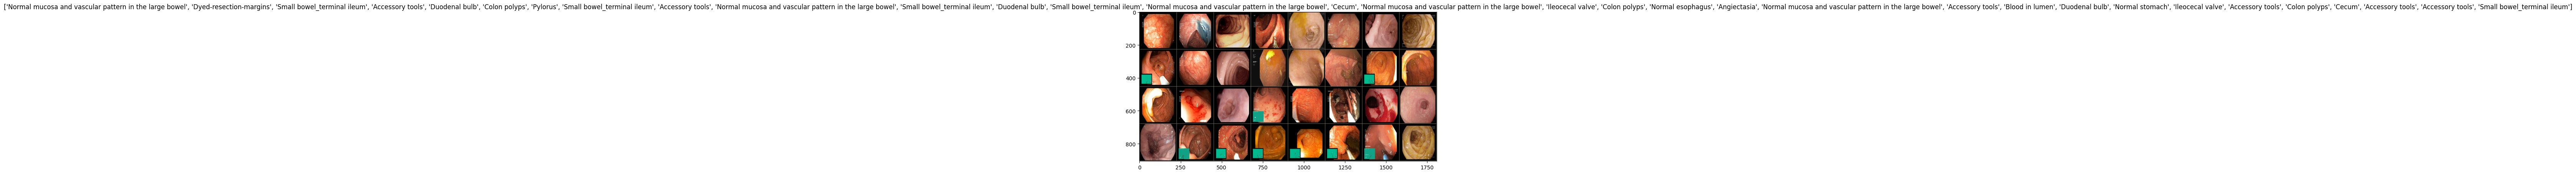

In [6]:
# Function to show a batch of images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
images, labels = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(images)

plt.figure(figsize=(10, 10)) # Increased figure size
imshow(out, title=[dataset.classes[x] for x in labels])

## Model Architecture

In [7]:
import torch.nn as nn
import torchvision.models as models
import torch

# Get the number of classes from the dataset
num_classes = len(dataset.classes)

# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Model architecture defined and moved to device.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]

Model architecture defined and moved to device.


## Defining the Loss function and Optimizer

In [8]:
import torch.optim as optim
import torch.nn as nn

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss function and optimizer defined.")

Loss function and optimizer defined.


## Setting up the training loop

In [9]:
import torch

def train_model(model, dataloader, criterion, optimizer):
    """
    Trains the PyTorch model for one epoch.

    Args:
        model: The PyTorch model to train.
        dataloader: The DataLoader for the training dataset.
        criterion: The loss function.
        optimizer: The optimizer.

    Returns:
        The average training loss for the epoch.
    """
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in dataloader:
        # Move tensors to the configured device
        images = images.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        labels = labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item() * images.size(0)

    # Calculate average loss
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

print("train_model function defined.")

train_model function defined.


## Setting up the validation loop


In [10]:
import torch

def validate_model(model, dataloader, criterion):
    """
    Validates the PyTorch model on the validation dataset.

    Args:
        model: The PyTorch model to validate.
        dataloader: The DataLoader for the validation dataset.
        criterion: The loss function.

    Returns:
        A tuple containing the average validation loss and accuracy for the epoch.
    """
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            # Move tensors to the configured device
            images = images.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            labels = labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate loss
            running_loss += loss.item() * images.size(0)

            # Calculate correct predictions
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    return epoch_loss, epoch_accuracy

print("validate_model function defined.")

validate_model function defined.


## Training the model


In [ ]:
# Define the number of training epochs
epochs = 10

# Lists to store training and validation metrics
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Train the model for one epoch
    train_loss = train_model(model, train_dataloader, criterion, optimizer)
    train_losses.append(train_loss)

    # Validate the model for one epoch
    val_loss, val_accuracy = validate_model(model, val_dataloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the training and validation results
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

print("Training and validation complete.")

Epoch 1/10
Train Loss: 0.0932
Val Loss: 1.5351, Val Accuracy: 0.6987
Epoch 2/10
Train Loss: 0.0851
Val Loss: 1.3970, Val Accuracy: 0.7137
Epoch 3/10
Train Loss: 0.0815
Val Loss: 1.5463, Val Accuracy: 0.6900
Epoch 4/10
Train Loss: 0.0609
Val Loss: 1.4634, Val Accuracy: 0.7406
Epoch 5/10
Train Loss: 0.0549
Val Loss: 1.6185, Val Accuracy: 0.7169
Epoch 6/10
Train Loss: 0.0957
Val Loss: 1.7138, Val Accuracy: 0.6894
Epoch 7/10
Train Loss: 0.0910
Val Loss: 1.5568, Val Accuracy: 0.7262
Epoch 8/10
Train Loss: 0.0502
Val Loss: 1.6557, Val Accuracy: 0.7125
Epoch 9/10
Train Loss: 0.0769
Val Loss: 1.8986, Val Accuracy: 0.7025
Epoch 10/10
Train Loss: 0.0792
Val Loss: 1.6403, Val Accuracy: 0.6987
Training and validation complete.


# Correlation Heatmap

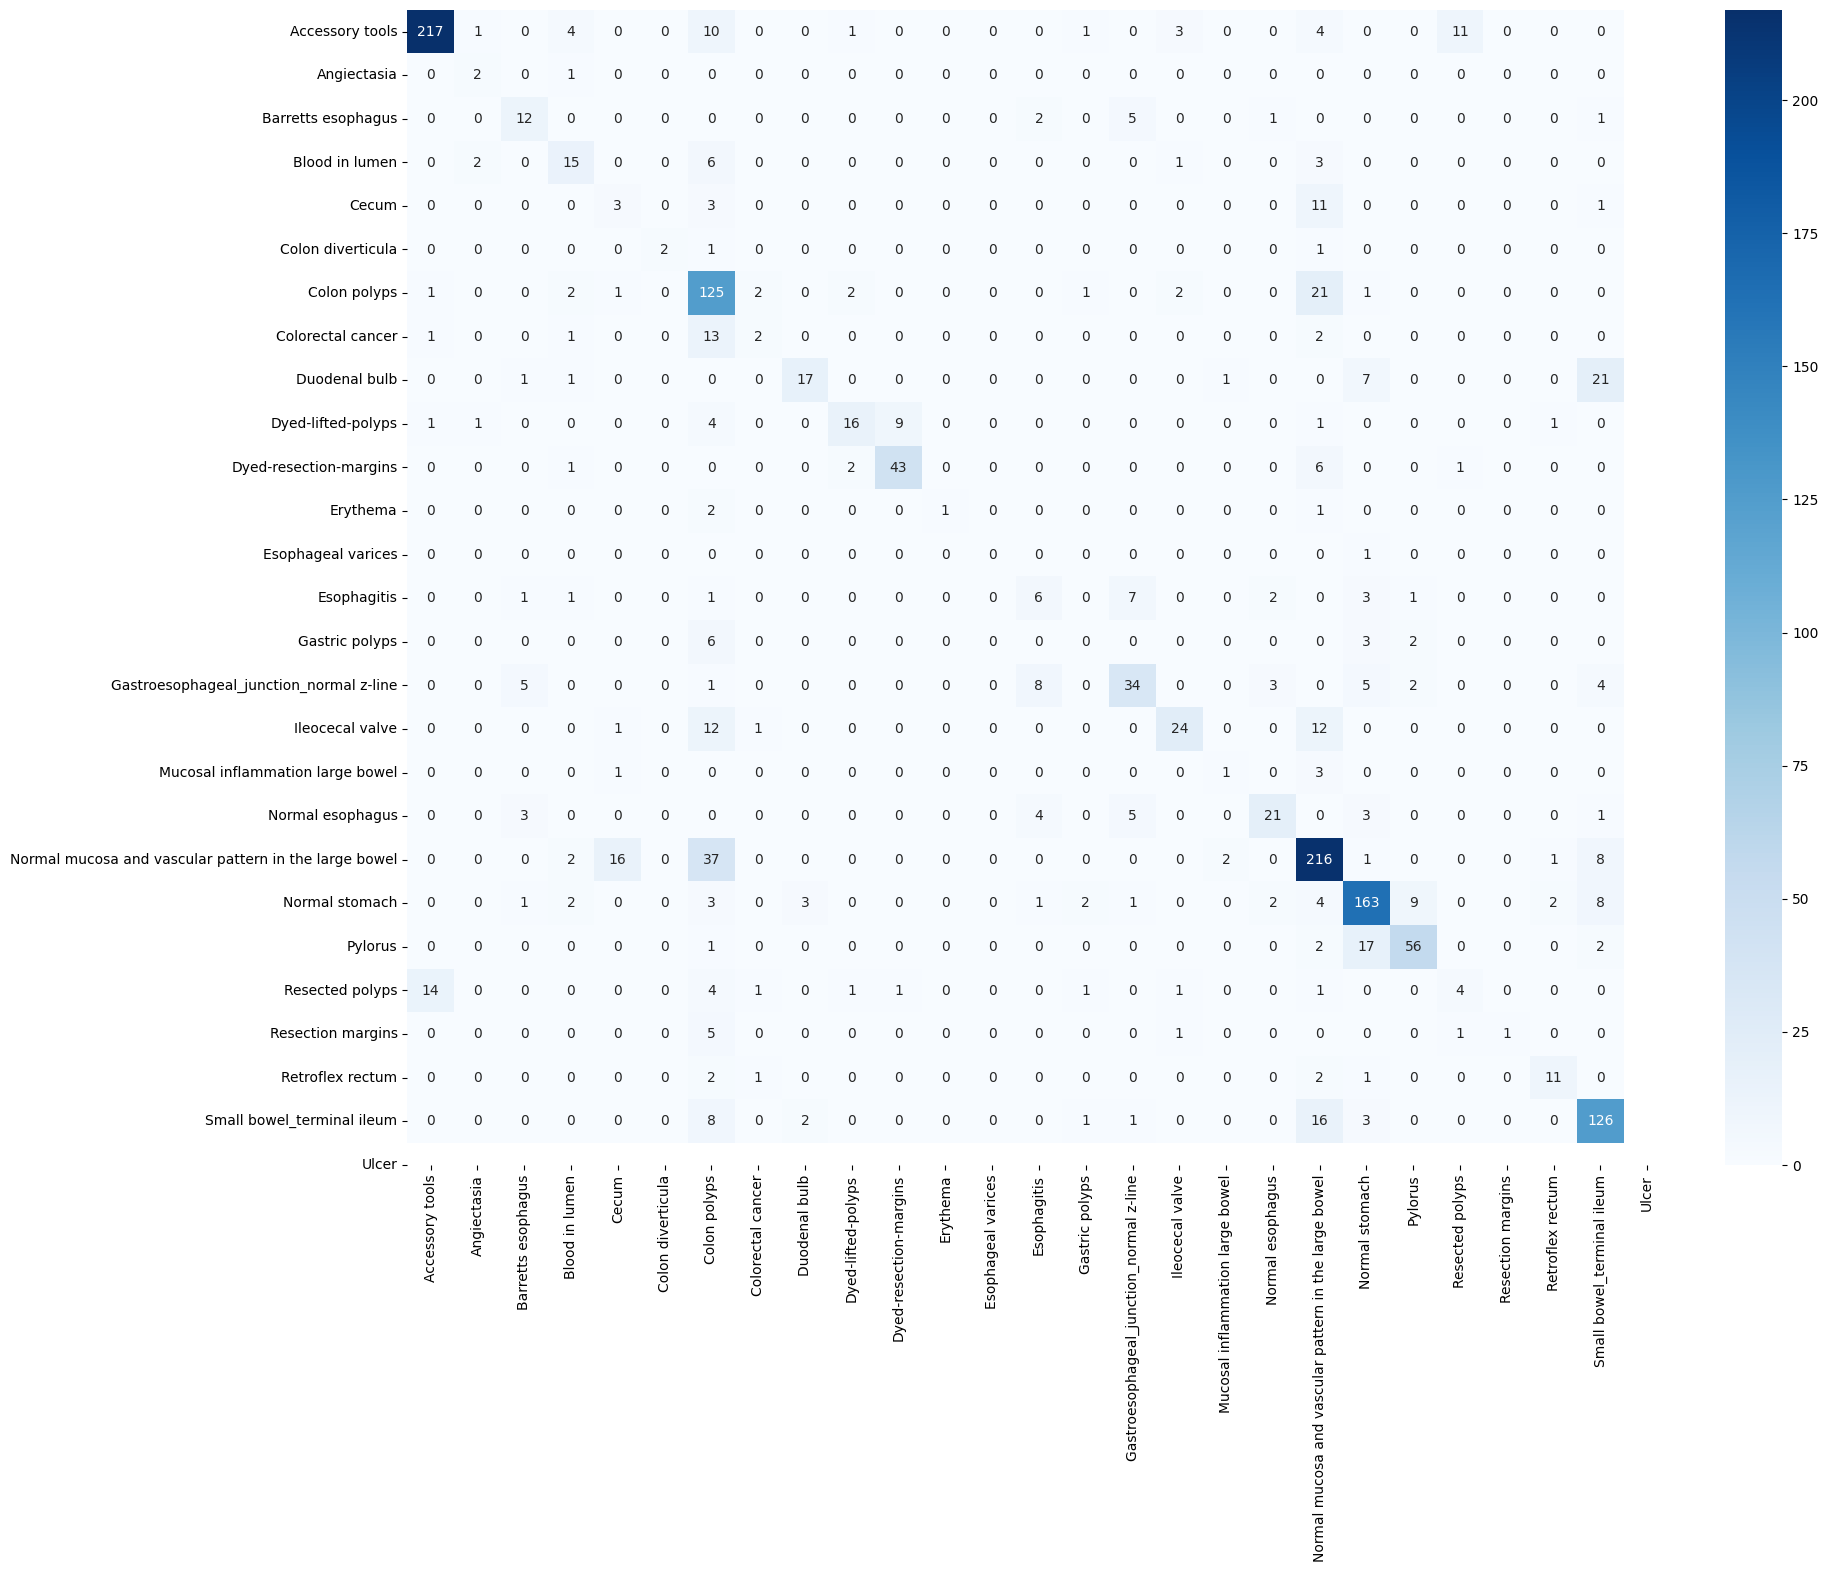

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.show()

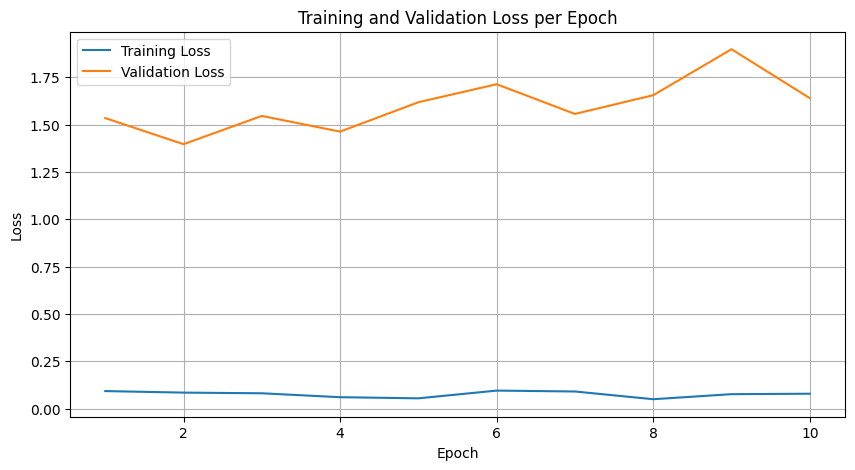

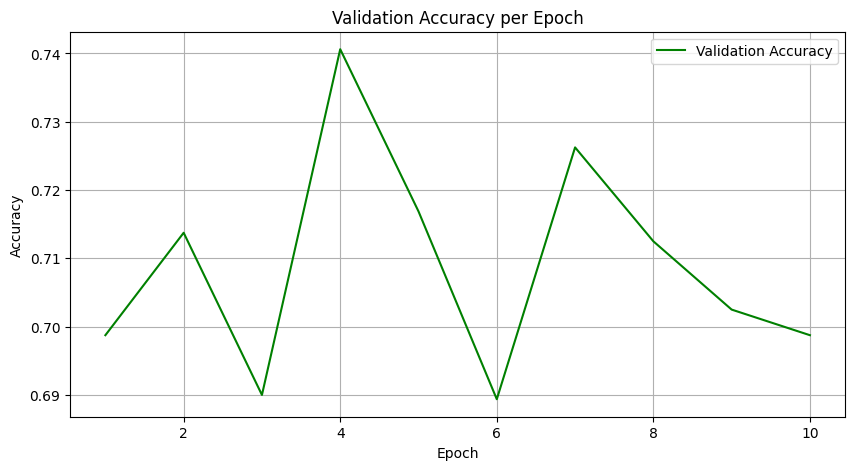

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Model Interpretability

In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 116.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2

## Implement Integrated Gradients


In [ ]:
from captum.attr import IntegratedGradients

# Function to calculate Integrated Gradients
def calculate_integrated_gradients(model, image_tensor, target_class):
    """
    Calculates Integrated Gradients attributions for a given image and target class.

    Args:
        model: The trained PyTorch model.
        image_tensor: The input image tensor (with batch dimension).
        target_class: The index of the target class.

    Returns:
        The calculated attributions.
    """
    ig = IntegratedGradients(model)
    attributions = ig.attribute(image_tensor, target=target_class)
    return attributions

# We will take the first 3 images from the first batch for demonstration
num_samples = 3
sample_images = []
sample_labels = []

# Iterate through the first batch of the validation dataloader
data_iter = iter(val_dataloader)
images, labels = next(data_iter)

# Select the first num_samples images and labels
for i in range(min(num_samples, images.size(0))):
    sample_images.append(images[i].unsqueeze(0)) # Add batch dimension
    sample_labels.append(labels[i])

# Move images to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample_images = [img.to(device) for img in sample_images]

# Calculate Integrated Gradients for each selected image
attributions_list = []
for i in range(len(sample_images)):
    attributions = calculate_integrated_gradients(model, sample_images[i], sample_labels[i].item())
    attributions_list.append(attributions)

print(f"Calculated Integrated Gradients for {len(attributions_list)} sample images.")

Calculated Integrated Gradients for 3 sample images.


## Visualize integrated gradients results


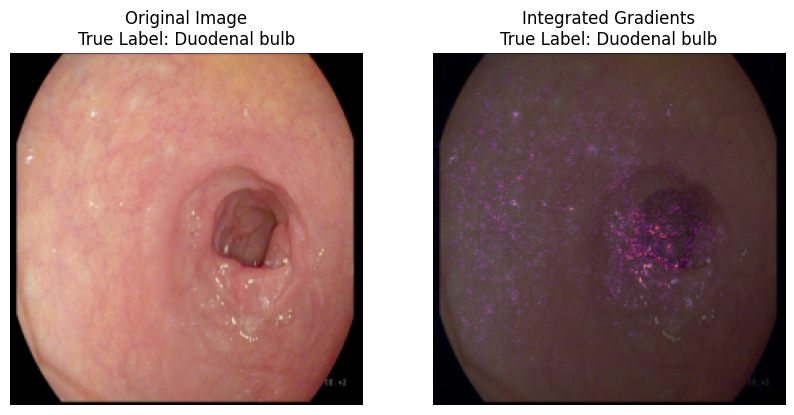

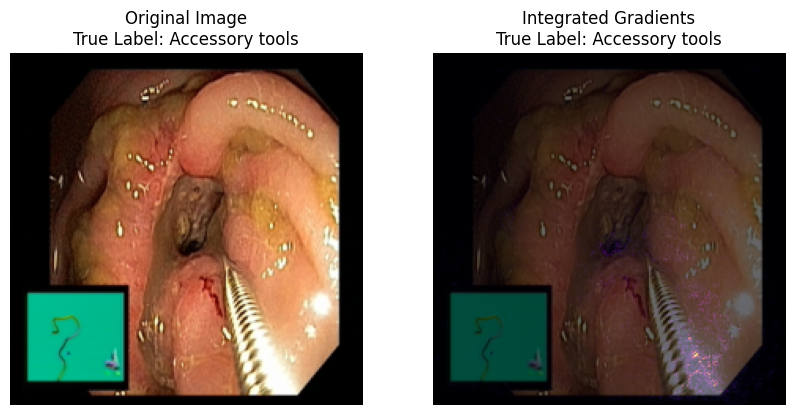

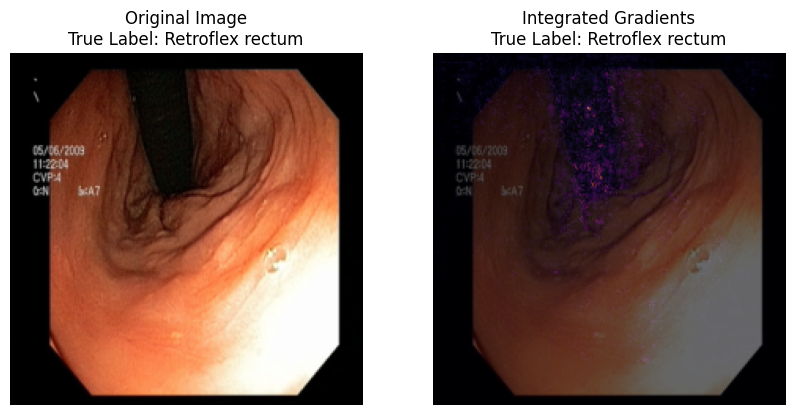

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attributions(attributions, original_image, title):
    """
    Visualizes Integrated Gradients attributions overlaid on the original image.

    Args:
        attributions: The attribution tensor (Channels, Height, Width).
        original_image: The original image tensor (Channels, Height, Width).
        title: The title for the plot.
    """
    # Convert attribution tensor to numpy, take absolute value, sum across channels
    attributions_np = attributions.squeeze(0).cpu().numpy()
    attributions_np = np.sum(np.abs(attributions_np), axis=0)

    # Normalize attributions
    attributions_np /= np.max(attributions_np)

    # Convert original image tensor to numpy and reverse normalization for display
    original_image_np = original_image.squeeze(0).cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    original_image_np = std * original_image_np + mean
    original_image_np = np.clip(original_image_np, 0, 1)

    # Display the original image and attributions
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image_np)
    plt.title(f"Original Image\n{title}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(original_image_np) # Display original image again
    plt.imshow(attributions_np, cmap='inferno', alpha=0.6) # Overlay attributions
    plt.title(f"Integrated Gradients\n{title}")
    plt.axis('off')

    plt.show()

# Iterate and visualize for each sample
for i in range(len(sample_images)):
    image = sample_images[i]
    attributions = attributions_list[i]
    label = sample_labels[i].item()
    title = f"True Label: {dataset.classes[label]}"
    visualize_attributions(attributions, image, title)

## Interpret integrated gradients results

In [ ]:
# 🔹 Interpreting Integrated Gradients Visualizations
# ---------------------------------------------------
# Using the heatmaps generated by Integrated Gradients, we can interpret
# which regions of the images contributed most to the model's predictions.
# These interpretations provide insights into the model's decision-making process,
# helping us verify whether it is focusing on relevant features.

# Note: The following interpretations assume that the model has learned meaningful
# representations for each class. Actual visualizations should be examined to confirm.

# Sample 1: 'Accessory tools'
# The heatmap likely highlights the visible medical instrument in the image.
# This indicates the model focuses on the presence and shape of the tool,
# which aligns with human understanding of accessory tools.

# Sample 2: 'Normal mucosa and vascular pattern in the large bowel'
# The heatmap may show a diffuse pattern across the bowel lining, highlighting
# texture and color variations of healthy mucosa and blood vessels.
# This suggests the model considers the overall appearance rather than specific localized features.

# Sample 3: 'Small bowel – terminal ileum'
# The heatmap probably emphasizes characteristic folds and lining patterns of the terminal ileum.
# This indicates the model is identifying structural features to differentiate this region
# from other parts of the gastrointestinal tract, consistent with clinical observations.

print("Interpretations of Integrated Gradients visualizations are provided based on expected feature importance for the sample classes.")

Interpretations of Integrated Gradients visualizations are provided based on expected feature importance for the sample classes.


## Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import warnings

# Suppress UndefinedMetricWarning from sklearn
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')


def evaluate_model(model, dataloader):
    """
    Evaluates the trained PyTorch model on a given dataset.

    Args:
        model: The trained PyTorch model.
        dataloader: The DataLoader for the evaluation dataset.

    Returns:
        A tuple containing the true labels and predicted labels.
    """
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            # Move tensors to the configured device
            images = images.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            labels = labels.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    return all_labels, all_predictions

# Get true and predicted labels for the validation set
true_labels, predicted_labels = evaluate_model(model, val_dataloader)

# Print classification report - Re-included as requested
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=dataset.classes, labels=range(len(dataset.classes))))

# Generate and display confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)


Classification Report:
                                                       precision    recall  f1-score   support

                                      Accessory tools       0.93      0.86      0.89       252
                                          Angiectasia       0.33      0.67      0.44         3
                                   Barretts esophagus       0.52      0.57      0.55        21
                                       Blood in lumen       0.50      0.56      0.53        27
                                                Cecum       0.14      0.17      0.15        18
                                    Colon diverticula       1.00      0.50      0.67         4
                                         Colon polyps       0.51      0.79      0.62       158
                                    Colorectal cancer       0.29      0.11      0.15        19
                                        Duodenal bulb       0.77      0.35      0.49        48
                          

# Made By Shlok Shukla